## Predicting House Prices
The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

In this notebook, I use a version of the "House Prices" dataset from Kaggle that has been ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, our task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

### Load the dataset from CSV

In [2]:
house_price = pd.read_csv("data/house_price.csv")

### Investigate the data

In [3]:
#Column headers
house_price.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [4]:
#Datatypes for each variable
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
house_price.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
#Descriptive stats:
house_price.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Data Cleaning

In [7]:
#Check if any values are NaN and need to be fixed or dropped
print((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(20))

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garageyrblt     0.055479
garagecond      0.055479
garagetype      0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtfintype2    0.026027
bsmtexposure    0.026027
bsmtqual        0.025342
bsmtcond        0.025342
bsmtfintype1    0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
id              0.000000
dtype: float64


In creating a model for 'saleprice', we aren't going to need all 81 features provided in the dataset. The ones shown above, which contain some portion of NaNs, don't seem like they would be the most useful features in predicting saleprice, so, because there's only 19 of them, and we'll have plenty of features left, I feel comfortable dropping these features from the dataset entirely. Additionally, because each row has a unique 'id' value, we should remove that feature as well, since it won't affect our regression either way.

In [8]:
#Drop features
drop_list = list((house_price.isnull().sum()/house_price.isnull().count()).sort_values(ascending=False).head(19).index)
drop_list.append('id')

house_price = house_price.drop(drop_list, axis=1)

In [9]:
#Check if it was successful
house_price.columns

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'exterqual', 'extercond', 'foundation',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'garagecars', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch',
       'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition', 'saleprice'],
      dtype='object')

Now that NaNs have been dealt with, we can visualize the dataset for some basic investigation into how the features affect each other (and especially how they affect saleprice). One thing to notice: some variables are numerical and continuous (i.e. saleprice, lotarea, lotfrontage, etc) while others appear to be numerical but actually represent categories of a catgegorical variable with finite values (yearbuilt, fullbath, yrsold, etc), and the final group is that of features that appear categorical (i.e. string objects: street, mssubclass, etc). Let's get all of those variables into a format that a regression can use.

### Exploratory Data Analysis

In [10]:
uniques = pd.DataFrame()
uni_col = []
num_uni = []
avgdiff_uni = []

for col in list(house_price.columns):
    uni_col.append(list(np.unique(house_price[col])))
    num_uni.append(len(np.unique(house_price[col])))
    try:
        avgdiff_uni.append(np.mean(np.diff(np.unique(house_price[col]))))
    except: 
        avgdiff_uni.append('N/A')
    
uniques['Category'] = list(house_price.columns)
uniques['Unique Values'] = uni_col
uniques['Num Uniques'] = num_uni
uniques['Avg Diff Among Uniques'] = avgdiff_uni

uniques

,Category,Unique Values,Num Uniques,Avg Diff Among Uniques
0,mssubclass,"[20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 1...",15,12.142857
1,mszoning,"[C (all), FV, RH, RL, RM]",5,N/A
2,lotarea,"[1300, 1477, 1491, 1526, 1533, 1596, 1680, 186...",1073,199.57556
3,street,"[Grvl, Pave]",2,N/A
4,lotshape,"[IR1, IR2, IR3, Reg]",4,N/A
...,...,...,...,...
56,mosold,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12,1.0
57,yrsold,"[2006, 2007, 2008, 2009, 2010]",5,1.0
58,saletype,"[COD, CWD, Con, ConLD, ConLI, ConLw, New, Oth,...",9,N/A
59,salecondition,"[Abnorml, AdjLand, Alloca, Family, Normal, Par...",6,N/A


In [11]:
#Separate features into string categorical, numerical categorical, and numerical continuous

#List of features that are string categoricals
str_cat_cols = list(house_price.describe(include=['O']).columns)

#List of features that are numerical categoricals
    #If a numerical variable is categorical, its unique values will tend to be close to each other and there shouldn't
    #be too many unique values 
num_cat_cols = []
for col in list(house_price.columns):
    if col not in str_cat_cols:   
        if ((list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 2) or ((list(uniques[uniques['Category']==col]['Num Uniques'])[0] < 20) and (list(uniques[uniques['Category']==col]['Avg Diff Among Uniques'])[0] < 20))):
            num_cat_cols.append(col)
            
#List of features that are numerical continuous
cont_cols = []
for col in list(house_price.columns):
    if ((col not in str_cat_cols) and (col not in num_cat_cols)):
        cont_cols.append(col)
        
print('String Categoricals: \n', str_cat_cols)

print('\nNumerical Categoricals: \n', num_cat_cols)

print('\nContinuous: \n', cont_cols)

String Categoricals: 
 ['mszoning', 'street', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating', 'heatingqc', 'centralair', 'kitchenqual', 'functional', 'paveddrive', 'saletype', 'salecondition']

Numerical Categoricals: 
 ['mssubclass', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'mosold', 'yrsold']

Continuous: 
 ['lotarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'saleprice']


### Initial Visualization and Feature Selection

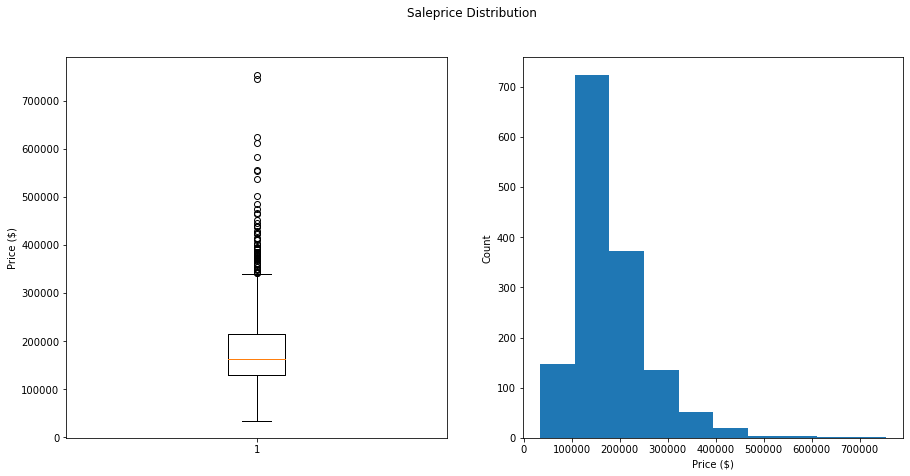

In [12]:
#Visualize data spread of our target variable, saleprice
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
box = plt.boxplot(house_price['saleprice'])
plt.ylabel('Price ($)')
  
plt.subplot(1,2,2)    
plt.hist(house_price['saleprice'])
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.suptitle('Saleprice Distribution')
plt.show()

We can see in this visualization that the saleprice data is not normally distributed. Its mean falls to the closer to the lower prices, and it stretches for a while toward the higher prices, meaning there are a lot of high outliers that could be skewing the distribution.

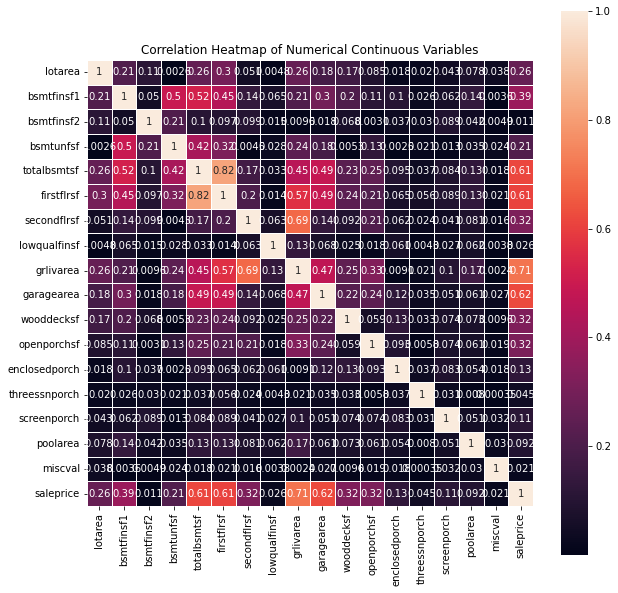

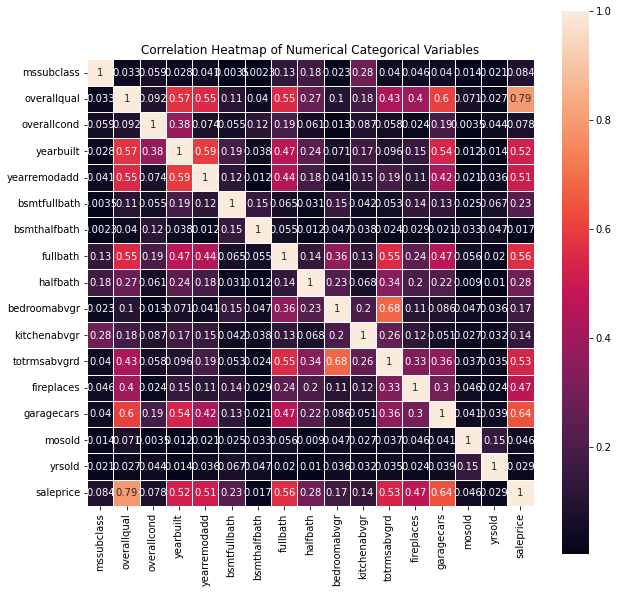

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

In [13]:
#Compare the continuous variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(house_price[cont_cols].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Numerical Continuous Variables')
plt.show()

num_cat_cols.append('saleprice')
#Compare the numerical categorical variables and their correlations via a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(abs(house_price[num_cat_cols].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Numerical Categorical Variables')
plt.show()

num_cat_cols.remove('saleprice')
abs(house_price[num_cat_cols+cont_cols].corr()['saleprice']).sort_values(ascending=False)

From our correlation list, we can see that the variables that are most highly correlated with 'saleprice' are: 'overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', and 'firstflrsf', respectively in that order.

From the heatmaps, we can see that these features aren't highly correlated with each other, so we probably don't have to worry about collinearity issues.

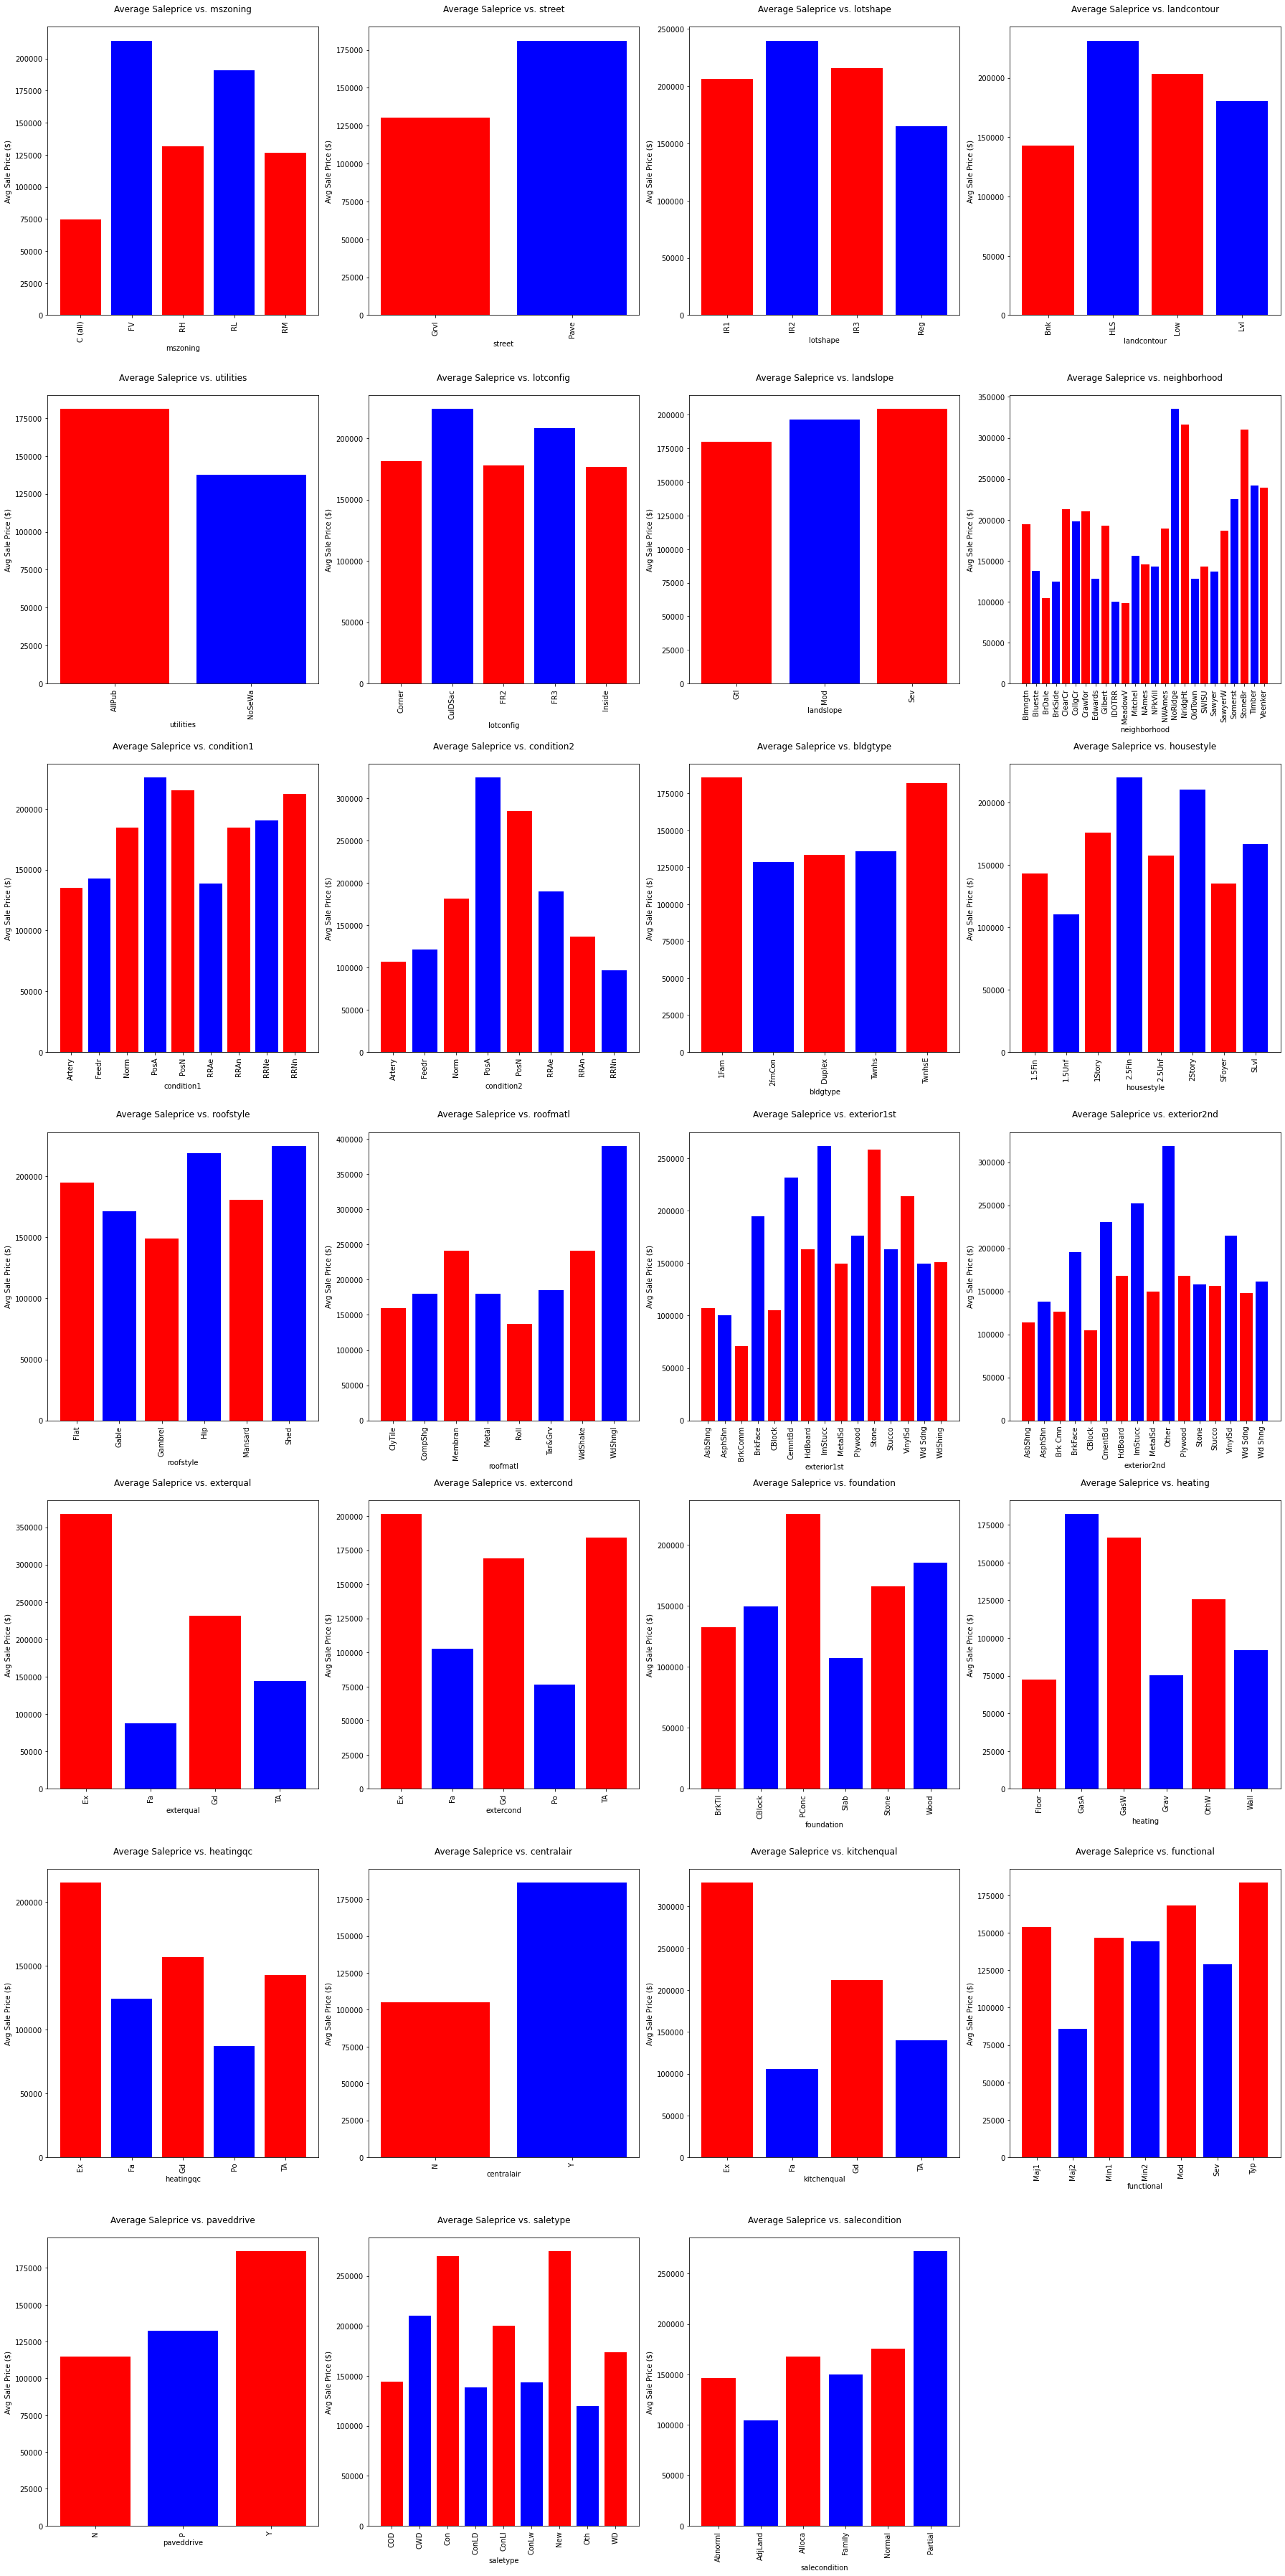

In [23]:
#Analyze all of the remaining variables (string categoricals), with respect to saleprice

#Bar chart with average saleprice on the y-axis and category on the x-axis
num_rows = int(len(str_cat_cols)/4) + 1
num_cols = 4

plt.figure(figsize=(25, 50))

for i in range(len(str_cat_cols)):
    plt.subplot(num_rows,num_cols,i+1)
    values = house_price.groupby(str_cat_cols[i])["saleprice"].mean()
    plt.bar(values.index, values, color=("red","blue"))
    plt.title('Average Saleprice vs. ' + str_cat_cols[i] + '\n')
    plt.ylabel('Avg Sale Price ($)')
    plt.xlabel(str_cat_cols[i])
    plt.xticks(rotation='vertical')
    
plt.tight_layout()
plt.show()

The variables 'paveddrive', 'street', 'utilities', 'landslope', and 'centralair' all show a linear or exponential relationship with saleprice. However, because most of these categorical variables are not ordinal, the order in which the categories are laid out could be impacting the visualization and our conclusions. Most likely, if the categories were re-ordered, we would see a similar relationship for every variable. But, for now, let's focus on 'street', 'landslope', and 'paveddrive', as I believe those would have significant impact on the saleprice. 

In [24]:
np.unique(house_price['landslope'])

array(['Gtl', 'Mod', 'Sev'], dtype=object)

In [25]:
#Create new dataframe containing features of interest
sale_df = house_price[['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'street', 'landslope','paveddrive']]

#Convert string categoricals ('street', 'landslope', and 'paveddrive') to dummy numericals
dummy_street = pd.get_dummies(sale_df['street'], prefix="street", drop_first=True)
sale_df = pd.concat([sale_df, dummy_street], axis=1)
#['Pave', 'Gravel']
sale_df = sale_df.drop('street', axis=1)

dummy_paved = pd.get_dummies(sale_df['paveddrive'], prefix="paveddrive")
sale_df = pd.concat([sale_df, dummy_paved], axis=1)
#['Y', 'P', 'N']
sale_df = sale_df.drop(['paveddrive', 'paveddrive_P'], axis=1)

dummy_slope = pd.get_dummies(sale_df['landslope'], prefix="landslope")
sale_df = pd.concat([sale_df, dummy_slope], axis=1)
#['Gtl', 'Mod', 'Sev']
sale_df = sale_df.drop(['landslope', 'landslope_Mod'], axis=1)

sale_df.head()

,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,street_Pave,paveddrive_N,paveddrive_Y,landslope_Gtl,landslope_Sev
0,208500,7,1710,2,548,856,856,1,0,1,1,0
1,181500,6,1262,2,460,1262,1262,1,0,1,1,0
2,223500,7,1786,2,608,920,920,1,0,1,1,0
3,140000,7,1717,3,642,756,961,1,0,1,1,0
4,250000,8,2198,3,836,1145,1145,1,0,1,1,0


In [26]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

#Test summary
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     432.4
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:34:53   Log-Likelihood:                -17482.
No. Observations:                1460   AIC:                         3.499e+04
Df Residuals:                    1448   BIC:                         3.505e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.145e+05   1.79e+04     -6.398

### Feature Engineering

In [27]:
list(sale_df.columns)

['saleprice',
 'overallqual',
 'grlivarea',
 'garagecars',
 'garagearea',
 'totalbsmtsf',
 'firstflrsf',
 'street_Pave',
 'paveddrive_N',
 'paveddrive_Y',
 'landslope_Gtl',
 'landslope_Sev']

In [28]:
#Combine area measurements into new feature
sale_df['total_size'] = sale_df['grlivarea'] + sale_df['garagearea'] + sale_df['totalbsmtsf'] + sale_df['firstflrsf']

#Interaction of total house size with overall quality
sale_df['size_qual'] = sale_df['total_size']*sale_df['overallqual']

In [29]:
#New summary
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     427.2
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:35:01   Log-Likelihood:                -17439.
No. Observations:                1460   AIC:                         3.490e+04
Df Residuals:                    1447   BIC:                         3.497e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1736.0311   2.12e+04     -0.082

## Split data into train and test sets

In [30]:
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


## OLS Regression Model

In [31]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.7707553283516099
-----Test set statistics-----
R-squared of the model in test set is: 0.8018938443211859
Mean absolute error of the prediction is: 24272.756161534293
Mean squared error of the prediction is: 1330026105.4704075
Root mean squared error of the prediction is: 36469.52296740948
Mean absolute percentage error of the prediction is: 14.724815874869043


## Do k-fold cross-validation to choose best hyperparameter values

In [32]:
alphas = [np.power(10.0,p) for p in np.arange(-20,40,1)]

## Lasso Regression Model

In [47]:
lassoregr = LassoCV(alphas=alphas, cv=len(alphas)) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("Best alpha parameter is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))

print("\n-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha parameter is: 10000.0
R-squared of the model on the training set is: 0.743905885908445

-----Test set statistics-----
R-squared of the model on the test set is: 0.8218124579484136
Mean absolute error of the prediction is: 22520.48973430541
Mean squared error of the prediction is: 1196298427.911802
Root mean squared error of the prediction is: 34587.54729540391
Mean absolute percentage error of the prediction is: 13.484952420046772


## Ridge Regression Model

In [46]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = RidgeCV(alphas=alphas, cv=len(alphas)) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("Best alpha parameter is: {}".format(ridgeregr.alpha_))
print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))

print("\n-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha parameter is: 100.0
R-squared of the model on the training set is: 0.7670880281681163

-----Test set statistics-----
R-squared of the model on the test set is: 0.8076050574809761
Mean absolute error of the prediction is: 23610.23938105353
Mean squared error of the prediction is: 1291682710.3830664
Root mean squared error of the prediction is: 35939.987623579764
Mean absolute percentage error of the prediction is: 14.221822472608741


## ElasticNet Regression Model

In [45]:
elasticregr = ElasticNetCV(alphas=alphas, cv=len(alphas)) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("Best alpha parameter is: {}".format(elasticregr.alpha_))
print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))

print("\n-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha parameter is: 10000.0
R-squared of the model on the training set is: 0.7437014560952224

-----Test set statistics-----
R-squared of the model on the test set is: 0.8229431017801194
Mean absolute error of the prediction is: 22462.648111615534
Mean squared error of the prediction is: 1188707619.8068993
Root mean squared error of the prediction is: 34477.639417554376
Mean absolute percentage error of the prediction is: 13.484966261136083


The best model, with respect to the training set results, is Lasso Regression, because it provides a good combination of high R-squared value and low error value. Using the Lasso model, 82.2% of the variance in the test data can be explained by the model and there is a 13.5% error rate among predictions.

## External Variables
We know that the dataset describes residential homes sold in Ames, Iowa. By incorporating a [dataset](https://fred.stlouisfed.org/series/INTDSRUSM193N) containing interest rates in that area during the years (2006-2010) represented within the dataset, we may find interesting changes in the model's performance.

In [36]:
print(np.unique(house_price['yrsold']))
print(np.unique(house_price['mosold']))

[2006 2007 2008 2009 2010]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


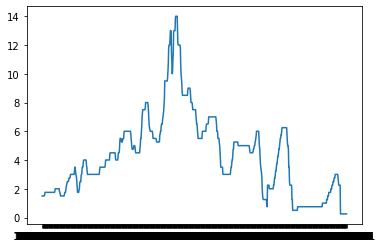

In [38]:
#Upload interest CSV and visualize
interest_df = pd.read_csv('data/interest-houses.csv')
plt.plot(interest_df['DATE'], interest_df['INTDSRUSM193N'])
plt.show()

In [39]:
months = []
years = []
for i in range(len(interest_df['DATE'])):
    years.append(int(interest_df['DATE'][i][:4]))
    months.append(int(interest_df['DATE'][i][5:7]))
    
interest_df['YEAR'] = years
interest_df['MONTH'] = months
interest_df['INTEREST_RATE'] = list(interest_df['INTDSRUSM193N'])

interest_df = interest_df.drop(['DATE', 'INTDSRUSM193N'], axis = 1)

interest_df.head()

,YEAR,MONTH,INTEREST_RATE
0,1950,1,1.5
1,1950,2,1.5
2,1950,3,1.5
3,1950,4,1.5
4,1950,5,1.5


In [40]:
#Combine house_price and interest_rate
interest = []
for i in range(len(house_price)):
    interest.append(list(interest_df['INTEREST_RATE'][interest_df['YEAR']==house_price['yrsold'][i]][interest_df['MONTH']==house_price['mosold'][i]])[0])
    
sale_df['interest_rate'] = interest
sale_df.columns

Index(['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea',
       'totalbsmtsf', 'firstflrsf', 'street_Pave', 'paveddrive_N',
       'paveddrive_Y', 'landslope_Gtl', 'landslope_Sev', 'total_size',
       'size_qual', 'interest_rate'],
      dtype='object')

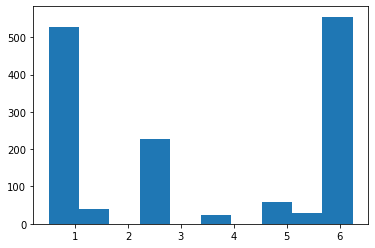

In [41]:
plt.hist(sale_df['interest_rate'])
plt.show()

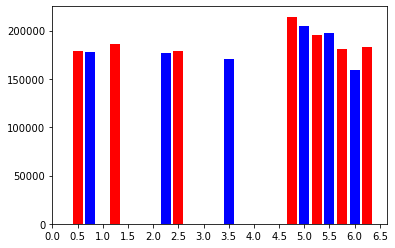

In [42]:
plt.figure()
values = sale_df.groupby('interest_rate')['saleprice'].mean()
plt.bar(values.index, values, width = 0.2, color=("red","blue"))
plt.xticks(np.arange(0,7,0.5))
plt.show()

In [44]:
#Re-run our model with the new interest rate data

#Split into test and train
target_var = 'saleprice'
feature_set = list(sale_df.columns.drop(['saleprice']))

# X is the feature set 
X = sale_df[feature_set]
# Y is the target variable
Y = sale_df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print("\n")

#Lasso Regression:
lassoregr = LassoCV(alphas=alphas, cv=len(alphas)) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("Best alpha parameter is: {}".format(lassoregr.alpha_))
print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))

print("\n-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


The number of observations in training set is 1168
The number of observations in test set is 292


Best alpha parameter is: 10000.0
R-squared of the model on the training set is: 0.743905885908445

-----Test set statistics-----
R-squared of the model on the test set is: 0.8218124579484136
Mean absolute error of the prediction is: 22520.48973430541
Mean squared error of the prediction is: 1196298427.911802
Root mean squared error of the prediction is: 34587.54729540391
Mean absolute percentage error of the prediction is: 13.484952420046772


Including the interest rate from an external dataset doesn't seem to improve the model very much. The percent error goes down slightly, but the R-squared value stays relatively constant. I couldn't find any quantitative datasets detailing economic activity during this time period, but I would assume that the housing market crash and Great Recession (~2008) would have had a significant impact on sale prices. However, before creating this model, I investigated all of the features in the dataset and found that the date of the house's sale had very little correlation with the sale price, and I'm not sure why that is.